In [1]:
import os
os.chdir('../../')

In [2]:
%%capture
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as datasets
from models import mlp,cmlp
from utilities import fits
from flax import linen as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss

In [3]:
X,Y =  datasets.make_moons(200, noise=0.2)

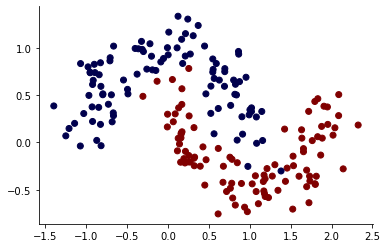

In [4]:
plt.scatter(X[:,0],X[:,1],c=Y,cmap='seismic')
sns.despine()

In [5]:
h=0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, h),
                     jnp.arange(y_min, y_max, h))

In [6]:
xx.shape

(205, 287)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [8]:
model = cmlp.cmlp([16,32,64,32,16,1],[nn.relu,nn.relu,nn.relu,nn.relu,nn.relu],[0,0,0,0,0])


In [9]:
auxs = {
    "X" : X_train,
    "y" : y_train,
    "deterministic": True,
}


In [10]:
seed=0
params = model.init(jax.random.PRNGKey(seed), X_train, deterministic = True)
params, loss =  fits.fit(model, params, auxs, learning_rate=0.01, epochs=100, verbose=True)

Loss step 0:  0.6863119
Loss step 10:  0.31851935
Loss step 20:  0.2711376
Loss step 30:  0.23612665
Loss step 40:  0.15372743
Loss step 50:  0.07099602
Loss step 60:  0.042731382
Loss step 70:  0.030527528
Loss step 80:  0.023667226
Loss step 90:  0.02183382


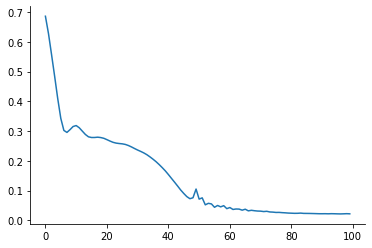

In [11]:
plt.plot(jnp.arange(0,100,1),loss)
sns.despine()

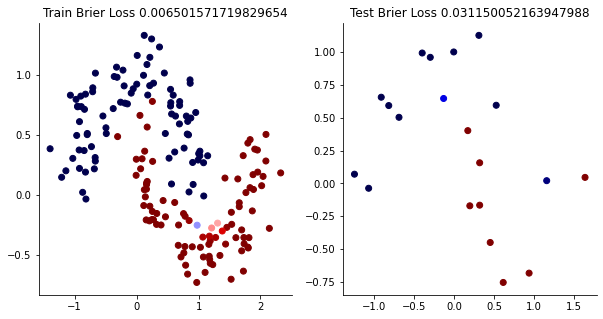

In [12]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
y_pred_train = model.apply(params, X_train, deterministic=True)
y_pred_test = model.apply(params, X_test, deterministic=True)
ax1.scatter(X_train[:,0],X_train[:,1],c=y_pred_train,cmap='seismic')
ax1.set_title(f'Train Brier Loss {brier_score_loss(y_train,y_pred_train)}')
ax2.scatter(X_test[:,0],X_test[:,1],c=y_pred_test,cmap='seismic')
ax2.set_title(f'Test Brier Loss {brier_score_loss(y_test,y_pred_test)}')
# ax2.set_title(brier_score_loss(y_test,y_pred_test))
sns.despine()




In [13]:
p =model.apply(params,jnp.c_[xx.ravel(), yy.ravel()],deterministic=True).reshape(xx.shape)
var = p*(1-p).reshape(xx.shape)


KeyboardInterrupt: 

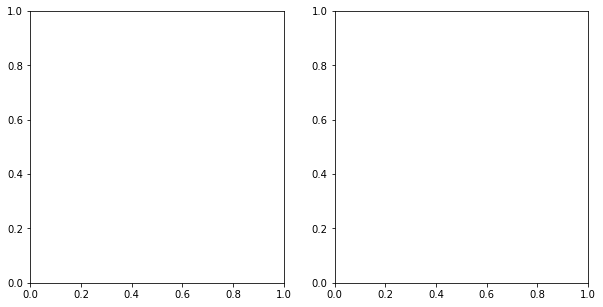

In [14]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax2.contourf(xx, yy, var,cmap='viridis')
ax1.contourf(xx, yy, p,cmap='coolwarm')
ax1.set_title('Probability')
ax1.scatter(X[:,0],X[:,1],c=Y,alpha=1,cmap='seismic')
ax2.scatter(X[:,0],X[:,1],c=Y,alpha=1,cmap='seismic')
ax2.set_title('Var')
sns.despine()

In [ ]:
params_lst= []
loss_lst =[]
for i in range(5):
    params =  model.init(jax.random.PRNGKey(i),X,deterministic=True)
    params,loss = fits.fit(model, params, auxs, learning_rate=0.01, epochs=100, verbose=False)
    params_lst.append(params)
    loss_lst.append(loss)

    

In [ ]:
p_de_train_ensemble = []
p_de_test_ensemble = []

for i in range(10):
    p =model.apply(params,X_train,deterministic=True)
    p_de_train_ensemble.append(p)
    p =model.apply(params,X_test,deterministic=True)
    p_de_test_ensemble.append(p)
p_de_train_mean = jnp.array(p_de_train_ensemble).mean(axis=0).reshape(y_train.shape)
p_de_test_mean = jnp.array(p_de_test_ensemble).mean(axis=0).reshape(y_test.shape)



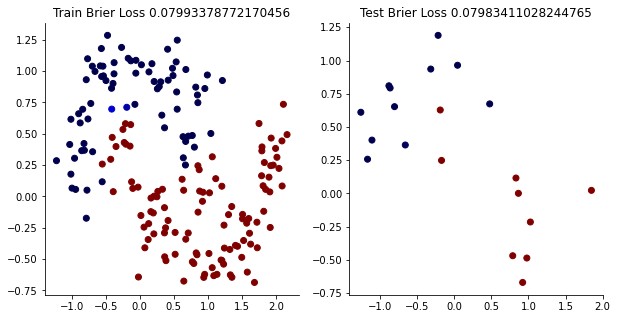

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
y_pred_train = model.apply(params, X_train, deterministic=True)
y_pred_test = model.apply(params, X_test, deterministic=True)
ax1.scatter(X_train[:,0],X_train[:,1],c=y_pred_train,cmap='seismic')
ax1.set_title(f'Train Brier Loss {brier_score_loss(y_train,y_pred_train)}')
ax2.scatter(X_test[:,0],X_test[:,1],c=y_pred_test,cmap='seismic')
ax2.set_title(f'Test Brier Loss {brier_score_loss(y_test,y_pred_test)}')
sns.despine()




In [ ]:
p_grid_ensemble = []

for i in range(10):
    p =model.apply(params,jnp.c_[xx.ravel(), yy.ravel()],deterministic=True).reshape(xx.shape)
    p_grid_ensemble.append(p)
p_mean = jnp.array(p_grid_ensemble).mean(axis=0)
p_sigma =  jnp.array(p_grid_ensemble).std(axis=0)


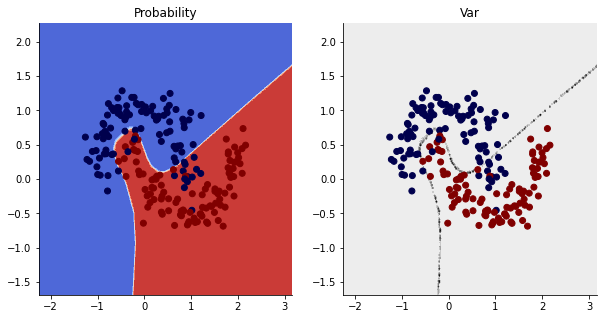

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax2.contourf(xx, yy, p_sigma,cmap='binary')
ax1.contourf(xx, yy, p_mean,cmap='coolwarm')
ax1.set_title('Probability')
ax1.scatter(X[:,0],X[:,1],c=Y,alpha=1,cmap='seismic')
ax2.scatter(X[:,0],X[:,1],c=Y,alpha=1,cmap='seismic')
ax2.set_title('Var')

sns.despine()

### MC Dropout

In [ ]:
y_stacks = []

@jax.jit
def func(params, i):
    z = model.apply(params, jnp.c_[xx.ravel(), yy.ravel()], deterministic=False, 
                    rngs={"dropout": jax.random.PRNGKey(i)}).reshape(xx.shape)
    return z
y_stacks = jax.vmap(fun=func, in_axes=(None, 0))(params, jnp.arange(100))

In [ ]:
p_mc_grid = jnp.array(y_stacks).mean(axis=0)
p_sigma_grid = jnp.array(y_stacks).std(axis=0)


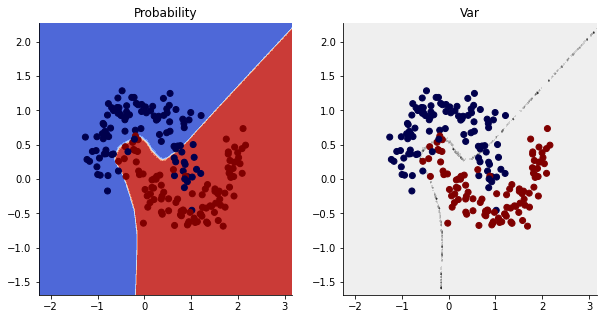

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax2.contourf(xx, yy, p_sigma_grid,cmap='binary')
ax1.contourf(xx, yy, p_mc_grid,cmap='coolwarm')
ax1.set_title('Probability')
ax1.scatter(X[:,0],X[:,1],c=Y,alpha=1,cmap='seismic')
ax2.scatter(X[:,0],X[:,1],c=Y,alpha=1,cmap='seismic')
ax2.set_title('Var')
sns.despine()